In [1]:
import numpy as np
import torch
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
import scipy.stats as stats
import sys

from torch import Tensor
from tqdm import trange
from pathlib import Path

# ensure project root is importable
PROJECT_ROOT = Path.cwd().parent.resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from data.multimarginal_generation import generate_multiscale_grf_data

In [11]:
# Generate data
T = 1
n_samples = 5000
n_constraints = 3
device = 'cuda'
resolution = 64
L_domain = 1.0
micro_corr_length = 0.15
H_max_factor = 0.5
H_divisor = 4.0
mean_val = 10.0
std_val = 2.0
covariance_type = 'exponential'
generation_method = 'kl'
kl_error_threshold = 0.01
schedule_type = 'concentrated'
concentration = 3.0


marginal_data, data_dim = generate_multiscale_grf_data(
    T=T,
    N_samples=n_samples,
    N_constraints=n_constraints,
    resolution=resolution,
    L_domain=L_domain,
    micro_corr_length=micro_corr_length,
    H_max_factor=H_max_factor,
    mean_val=mean_val,
    std_val=std_val,
    covariance_type=covariance_type,
    device=device,
    generation_method=generation_method,
    kl_error_threshold=kl_error_threshold,
    schedule_type=schedule_type,
    H_divisor=H_divisor,
    concentration=concentration
)


In [12]:
def suggest_filter_params(
    resolution: int,
    L_domain: float = 1.0,
    micro_corr_length: float | None = None,
    H_divisor: float | None = None,
    H_max_factor: float | None = None,
    desired_H_meaning: str = 'diameter',
) -> dict:
    """Suggest sensible choices for `H_divisor` and `H_max_factor` and report mappings.

    Parameters
    - resolution: spatial resolution (number of pixels per side)
    - L_domain: physical domain size (same units as H and micro_corr_length)
    - micro_corr_length: optional microscale correlation length (same units)
    - H_divisor: if provided, use this divisor; otherwise chosen from `desired_H_meaning`
    - H_max_factor: if provided, returned as the single recommendation; otherwise function returns a small set of recommended factors
    - desired_H_meaning: either `'diameter'` or `'sigma'`:
        - `'diameter'` (default): interprets `H` approximately as the kernel diameter (the code uses sigma = H / H_divisor and kernel ≈ 6*sigma so H_divisor=6 makes H ≈ kernel diameter)
        - `'sigma'`: interprets `H` as the Gaussian standard deviation (set H_divisor=1 so kernel ≈ 6*H)

    Returns
    A dict with computed `pixel_size`, `H_min_numerical`, `recommended_H_divisor`, a list of
    `candidate_H_max_factors`, and a `details` mapping for each candidate showing `H_max`,
    `H_max_pixels`, `sigma_pix`, `kernel_size` and simple advice relative to `micro_corr_length`.

    Notes
    - This helper mirrors the logic in `data/multimarginal_generation.py`:
       * `pixel_size = L_domain / resolution`
       * `filter_sigma_phys = H / H_divisor`
       * `filter_sigma_pix = filter_sigma_phys / pixel_size`
       * `kernel_size = int(max(3, round(6 * filter_sigma_pix)))` forced to odd
    - Use the returned numbers to choose `H_divisor` and `H_max_factor` so that
      the coarsest kernel (`H_max_pixels`) lies in a reasonable range (≈4 .. resolution/2).
    """
    from math import isfinite

    pixel_size = L_domain / float(resolution)

    if H_divisor is None:
        if desired_H_meaning == 'diameter':
            recommended_divisor = 6.0
        elif desired_H_meaning == 'sigma':
            recommended_divisor = 1.0
        else:
            recommended_divisor = 6.0
    else:
        recommended_divisor = float(H_divisor)

    # Numerical minimum used by the geometric schedule in the code
    H_min_numerical = 2.0 * recommended_divisor * pixel_size

    # Candidate H_max_factors if user didn't specify one
    if H_max_factor is None:
        candidate_factors = [0.2, 0.3, 0.5]
    else:
        candidate_factors = [float(H_max_factor)]

    details = {}
    for f in candidate_factors:
        H_max = L_domain * f
        H_max_pixels = H_max / pixel_size
        sigma_pix = H_max / (recommended_divisor * pixel_size) if recommended_divisor != 0 else float('inf')
        kernel_size = max(3, int(round(6.0 * sigma_pix)))
        # force odd kernel size (the code ensures odd by adding 1 when needed)
        if kernel_size % 2 == 0:
            kernel_size += 1

        advice = []
        if H_max_pixels < 4:
            advice.append('H_max too small: coarse-graining will be weak (H_max_pixels<4)')
        if H_max_pixels > resolution / 2:
            advice.append('H_max large: may oversmooth toward near-constant fields (H_max_pixels>resolution/2)')
        if micro_corr_length is not None and isfinite(micro_corr_length):
            if H_max < micro_corr_length * 2.0:
                advice.append('H_max not much larger than micro_corr_length; limited scale separation')
            else:
                advice.append('H_max meaningfully larger than micro_corr_length')

        details[f] = {
            'H_max': H_max,
            'H_max_pixels': H_max_pixels,
            'sigma_pix': sigma_pix,
            'kernel_size': kernel_size,
            'advice': advice,
        }

    return {
        'pixel_size': pixel_size,
        'H_min_numerical': H_min_numerical,
        'recommended_H_divisor': recommended_divisor,
        'candidate_H_max_factors': candidate_factors,
        'details': details,
    }


# Example usage and small pretty-print
params = suggest_filter_params(
    resolution=resolution,
    L_domain=L_domain,
    micro_corr_length=micro_corr_length,
    H_divisor=H_divisor,
)

import pprint
pprint.pprint(params)


{'H_min_numerical': 0.125,
 'candidate_H_max_factors': [0.2, 0.3, 0.5],
 'details': {0.2: {'H_max': 0.2,
                   'H_max_pixels': 12.8,
                   'advice': ['H_max not much larger than micro_corr_length; '
                              'limited scale separation'],
                   'kernel_size': 19,
                   'sigma_pix': 3.2},
             0.3: {'H_max': 0.3,
                   'H_max_pixels': 19.2,
                   'advice': ['H_max meaningfully larger than '
                              'micro_corr_length'],
                   'kernel_size': 29,
                   'sigma_pix': 4.8},
             0.5: {'H_max': 0.5,
                   'H_max_pixels': 32.0,
                   'advice': ['H_max meaningfully larger than '
                              'micro_corr_length'],
                   'kernel_size': 49,
                   'sigma_pix': 8.0}},
 'pixel_size': 0.015625,
 'recommended_H_divisor': 4.0}


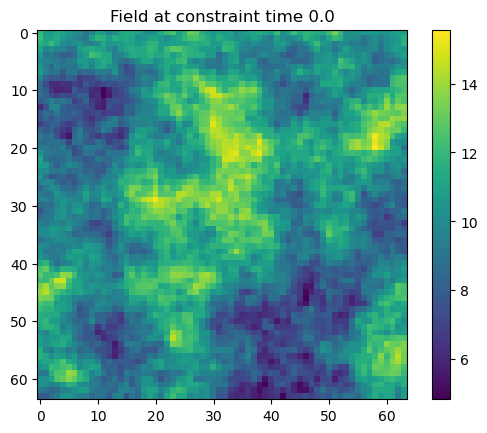

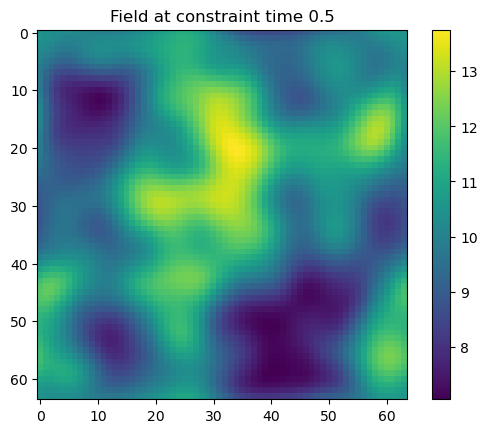

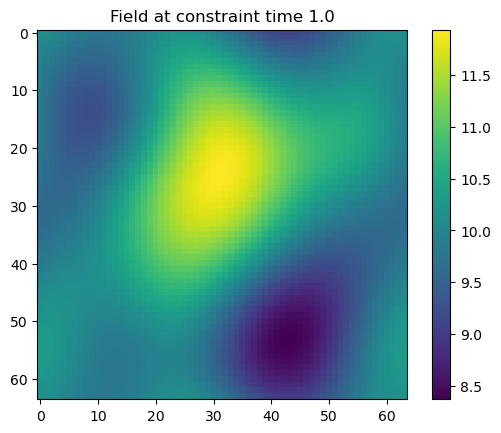

In [13]:
import matplotlib.pyplot as plt

# visualize the fields at all n_constraints
constraints_time = marginal_data.keys()
for t in constraints_time:
    fields = marginal_data[t].to('cpu').numpy()
    field_sample = fields[0]  # Select the first sample for visualization
    field_sample = field_sample.reshape(resolution, resolution)
    # Add visualization code here, for example using matplotlib    
    plt.imshow(field_sample)
    plt.title(f"Field at constraint time {t}")
    plt.colorbar()
    plt.show()